<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import shutil

**Enable GPU**

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


**Declare parameters**

In [3]:
ROOT_DIR = os.path.dirname(os.getcwd())

IMAGE_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001

SKIP_TRANSFER_LEARNING = True

# Input data

**Download Food101 dataset**

I will be using the labelled food-101 dataset that includes 101 different classes each containing 1000 images. If given directory not found then dataset is downloaded, extracted and the dataset is split into training and test images.

In [4]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TRAIN_DIR = os.path.join(FOOD101_DIR, "train")
VAL_DIR = os.path.join(FOOD101_DIR, "test")

if not os.path.exists(FOOD101_DIR):
  print("Downloading Food-101 dataset... ", end="")
  !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
  print("Done")


  print("Extracting data... ", end="")
  !tar xzvf food-101.tar.gz
  print("Done")
    
    
  print("Spliting dataset... ", end="")
  for split in ["train", "test"]:
    images = {}
    
    # extract image filenames
    with open(os.path.join(FOOD101_DIR, "meta", split+".txt"), 'r') as file:
      for path in file.readlines():
        path = path.strip()
        food_class, food_id = path.split('/')
        images.setdefault(food_class, []).append(food_id)
        
    # copy images into split directory
    for food_class in images.keys():
      # make class directory
      os.makedirs(os.path.join(FOOD101_DIR, split, food_class))

      # populate class directory with images
      for food_id in images[food_class]:
        src = os.path.join(FOOD101_DIR, "images", food_class, food_id+".jpg")
        dest = os.path.join(FOOD101_DIR, split, food_class, food_id+".jpg")
        shutil.copy(src, dest)
  print("Done")

**Format training images**

In [5]:
train_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_raw = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
train_size = len(train_raw)

train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True)

class_names = train_raw.classes

**Format validation images**

In [6]:
val_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_raw = torchvision.datasets.ImageFolder(VAL_DIR, transform=val_transform)
val_size = len(val_raw)

val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE)

**Show example images from dataset**

I have randomly selected and displayed 20 images from the training dataset along with their corresponding class.

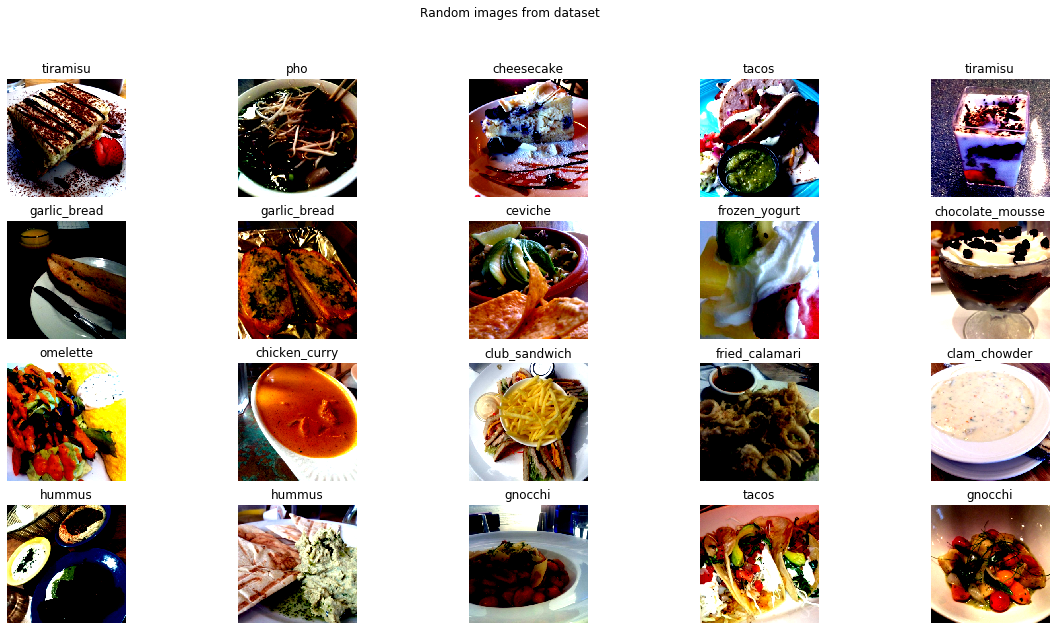

In [7]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Random images from dataset")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  j = np.random.randint(train_size)
  img = train_raw[j][0].numpy()
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  plt.title(class_names[train_raw[j][1]])
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()

# Model

**Fetch Model**

In order to train the food classifier I will initially use transfer learning from a pretrained InceptionV3 model. This involves replacing the classification head with a 101-way dense layer and freezing all other layers.

In [8]:
print("Fetching pretrained model... ", end="")
# fetch pre-trained feature extractor
model = torchvision.models.inception_v3(pretrained=True)

if not SKIP_TRANSFER_LEARNING:
    # freeze feature extractor
    for param in model.parameters():
      param.requires_grad = False

# handle auxilary net
num_features = model.AuxLogits.fc.in_features
model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

# handle primary net
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 101)

model = model.to(device)
print("done")

Fetching pretrained model... done


# Training via transfer learning

**Declare optimizer and loss function**

In [9]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.CrossEntropyLoss()

**Train model**

In [10]:
statistics = {
    "accuracy": [],
    "val_accuracy": []
}

def train():
  best_acc = 0.0
  best_model_weights = None

  print("Training on {} images...\n".format(train_size))

  for epoch in range(1, EPOCHS+1):
    print("Epoch {}/{}...".format(epoch, EPOCHS))

    model.train()
    running_loss = 0.0
    running_corrects = 0

    i = 0
    for (images, labels) in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      # reset the parameter gradients
      optimizer.zero_grad()

      # fit images on model
      outputs, aux_outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss1 = loss_func(outputs, labels)
      loss2 = loss_func(aux_outputs, labels)
      loss = loss1 + 0.4 * loss2
    
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(predictions == labels.data)
    
      i += 1
      print("Training Loss: {:.4f}, Acc: {:.4f}".format(running_loss / (i * BATCH_SIZE), running_corrects.double() / (i * BATCH_SIZE)))

    # calculate statistics
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    
    # print statistics
    print("Training Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss, epoch_acc))
    statistics['accuracy'].append(epoch_acc)
    
    val_loss, val_acc = validate()

    # save best model seen
    if val_acc > best_acc:
      best_acc = epoch_acc
      best_model_weights = copy.deepcopy(model.state_dict())

    # print statistics
    print("Validation Loss: {:.4f}, Acc: {:.4f}\n".format(val_loss, val_acc))
    statistics['val_accuracy'].append(val_acc)
    
  # reinstantiate best seen weights
  model.load_state_dict(best_model_weights)

  print("DONE")


def validate():
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

  # calculate statistics
  val_loss = running_loss / val_size
  val_acc = running_corrects.double() / val_size

  return val_loss, val_acc

if not SKIP_TRANSFER_LEARNING:
    train()

**Save model**

In [11]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "transfer_learning_v1.pt")

if not SKIP_TRANSFER_LEARNING:
    torch.save(model.state_dict(), MODEL_PATH)

**Evaluate transfer learning**

In [12]:
if not SKIP_TRANSFER_LEARNING:
    plt.plot(statistics['accuracy'], label='accuracy')
    plt.plot(statistics['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend(loc='lower right')

# Training via fine-tuning

In [13]:
if SKIP_TRANSFER_LEARNING:
    print("Loading transfer learning weights...", end="")
    model.load_state_dict(torch.load(MODEL_PATH))
    print("done")

Loading transfer learning weights...done


**Unfreeze layers in model**

In [14]:
if not SKIP_TRANSFER_LEARNING:
    for param in model.parameters():
        param.requires_grad = True

**Train model**

In [ ]:
statistics = {
    "accuracy": [],
    "val_accuracy": []
}

train()

Training on 75750 images...

Epoch 1/5...
Training Loss: 3.8230, Acc: 0.4688
Training Loss: 4.3725, Acc: 0.4062
Training Loss: 4.6835, Acc: 0.3333
Training Loss: 4.7455, Acc: 0.3281
Training Loss: 4.6160, Acc: 0.3500
Training Loss: 4.6143, Acc: 0.3385
Training Loss: 4.5021, Acc: 0.3661
Training Loss: 4.4191, Acc: 0.3828
Training Loss: 4.4131, Acc: 0.3819
Training Loss: 4.4173, Acc: 0.3688
Training Loss: 4.4543, Acc: 0.3722
Training Loss: 4.4536, Acc: 0.3828
Training Loss: 4.4257, Acc: 0.3870
Training Loss: 4.4083, Acc: 0.3973
Training Loss: 4.4406, Acc: 0.3937
Training Loss: 4.4701, Acc: 0.3984
Training Loss: 4.4794, Acc: 0.3971
Training Loss: 4.4986, Acc: 0.3906
Training Loss: 4.4701, Acc: 0.3980
Training Loss: 4.5112, Acc: 0.3922
Training Loss: 4.4891, Acc: 0.3973
Training Loss: 4.5188, Acc: 0.3963
Training Loss: 4.5142, Acc: 0.3913
Training Loss: 4.5239, Acc: 0.3893
Training Loss: 4.4936, Acc: 0.3987
Training Loss: 4.5159, Acc: 0.3930
Training Loss: 4.5096, Acc: 0.3947
Training Loss

Training Loss: 4.4202, Acc: 0.4113
Training Loss: 4.4217, Acc: 0.4113
Training Loss: 4.4188, Acc: 0.4119
Training Loss: 4.4168, Acc: 0.4122
Training Loss: 4.4166, Acc: 0.4116
Training Loss: 4.4163, Acc: 0.4116
Training Loss: 4.4150, Acc: 0.4115
Training Loss: 4.4156, Acc: 0.4112
Training Loss: 4.4179, Acc: 0.4109
Training Loss: 4.4180, Acc: 0.4109
Training Loss: 4.4213, Acc: 0.4103
Training Loss: 4.4199, Acc: 0.4105
Training Loss: 4.4189, Acc: 0.4108
Training Loss: 4.4160, Acc: 0.4109
Training Loss: 4.4156, Acc: 0.4110
Training Loss: 4.4126, Acc: 0.4113
Training Loss: 4.4106, Acc: 0.4119
Training Loss: 4.4100, Acc: 0.4117
Training Loss: 4.4088, Acc: 0.4115
Training Loss: 4.4089, Acc: 0.4112
Training Loss: 4.4081, Acc: 0.4110
Training Loss: 4.4087, Acc: 0.4112
Training Loss: 4.4078, Acc: 0.4109
Training Loss: 4.4071, Acc: 0.4106
Training Loss: 4.4078, Acc: 0.4106
Training Loss: 4.4068, Acc: 0.4105
Training Loss: 4.4072, Acc: 0.4103
Training Loss: 4.4080, Acc: 0.4102
Training Loss: 4.407

Training Loss: 4.4007, Acc: 0.4145
Training Loss: 4.4017, Acc: 0.4144
Training Loss: 4.4014, Acc: 0.4143
Training Loss: 4.4020, Acc: 0.4143
Training Loss: 4.4021, Acc: 0.4143
Training Loss: 4.4009, Acc: 0.4146
Training Loss: 4.4014, Acc: 0.4145
Training Loss: 4.4012, Acc: 0.4145
Training Loss: 4.4017, Acc: 0.4144
Training Loss: 4.4033, Acc: 0.4143
Training Loss: 4.4027, Acc: 0.4145
Training Loss: 4.4018, Acc: 0.4146
Training Loss: 4.4013, Acc: 0.4148
Training Loss: 4.4030, Acc: 0.4145
Training Loss: 4.4029, Acc: 0.4147
Training Loss: 4.4019, Acc: 0.4148
Training Loss: 4.4024, Acc: 0.4148
Training Loss: 4.4011, Acc: 0.4149
Training Loss: 4.4002, Acc: 0.4149
Training Loss: 4.3988, Acc: 0.4150
Training Loss: 4.3992, Acc: 0.4150
Training Loss: 4.3988, Acc: 0.4149
Training Loss: 4.3989, Acc: 0.4149
Training Loss: 4.3998, Acc: 0.4148
Training Loss: 4.3995, Acc: 0.4147
Training Loss: 4.3997, Acc: 0.4149
Training Loss: 4.4008, Acc: 0.4145
Training Loss: 4.4001, Acc: 0.4146
Training Loss: 4.400

Training Loss: 4.4052, Acc: 0.4148
Training Loss: 4.4060, Acc: 0.4147
Training Loss: 4.4060, Acc: 0.4148
Training Loss: 4.4058, Acc: 0.4148
Training Loss: 4.4056, Acc: 0.4149
Training Loss: 4.4051, Acc: 0.4150
Training Loss: 4.4049, Acc: 0.4151
Training Loss: 4.4060, Acc: 0.4150
Training Loss: 4.4061, Acc: 0.4149
Training Loss: 4.4054, Acc: 0.4151
Training Loss: 4.4057, Acc: 0.4151
Training Loss: 4.4061, Acc: 0.4151
Training Loss: 4.4066, Acc: 0.4151
Training Loss: 4.4060, Acc: 0.4151
Training Loss: 4.4053, Acc: 0.4151
Training Loss: 4.4058, Acc: 0.4151
Training Loss: 4.4054, Acc: 0.4152
Training Loss: 4.4064, Acc: 0.4149
Training Loss: 4.4068, Acc: 0.4148
Training Loss: 4.4060, Acc: 0.4149
Training Loss: 4.4060, Acc: 0.4150
Training Loss: 4.4057, Acc: 0.4150
Training Loss: 4.4053, Acc: 0.4149
Training Loss: 4.4057, Acc: 0.4151
Training Loss: 4.4051, Acc: 0.4153
Training Loss: 4.4045, Acc: 0.4153
Training Loss: 4.4050, Acc: 0.4152
Training Loss: 4.4055, Acc: 0.4151
Training Loss: 4.405

Training Loss: 4.4158, Acc: 0.4145
Training Loss: 4.4167, Acc: 0.4144
Training Loss: 4.4172, Acc: 0.4143
Training Loss: 4.4176, Acc: 0.4142
Training Loss: 4.4182, Acc: 0.4141
Training Loss: 4.4191, Acc: 0.4141
Training Loss: 4.4189, Acc: 0.4142
Training Loss: 4.4191, Acc: 0.4140
Training Loss: 4.4183, Acc: 0.4142
Training Loss: 4.4188, Acc: 0.4141
Training Loss: 4.4194, Acc: 0.4140
Training Loss: 4.4194, Acc: 0.4140
Training Loss: 4.4193, Acc: 0.4139
Training Loss: 4.4189, Acc: 0.4139
Training Loss: 4.4195, Acc: 0.4139
Training Loss: 4.4185, Acc: 0.4140
Training Loss: 4.4183, Acc: 0.4141
Training Loss: 4.4191, Acc: 0.4139
Training Loss: 4.4186, Acc: 0.4141
Training Loss: 4.4191, Acc: 0.4140
Training Loss: 4.4190, Acc: 0.4140
Training Loss: 4.4195, Acc: 0.4140
Training Loss: 4.4206, Acc: 0.4139
Training Loss: 4.4206, Acc: 0.4139
Training Loss: 4.4202, Acc: 0.4139
Training Loss: 4.4197, Acc: 0.4140
Training Loss: 4.4190, Acc: 0.4142
Training Loss: 4.4192, Acc: 0.4141
Training Loss: 4.419

Training Loss: 4.4249, Acc: 0.4140
Training Loss: 4.4250, Acc: 0.4140
Training Loss: 4.4252, Acc: 0.4139
Training Loss: 4.4253, Acc: 0.4139
Training Loss: 4.4250, Acc: 0.4140
Training Loss: 4.4254, Acc: 0.4140
Training Loss: 4.4253, Acc: 0.4140
Training Loss: 4.4255, Acc: 0.4140
Training Loss: 4.4255, Acc: 0.4140
Training Loss: 4.4255, Acc: 0.4140
Training Loss: 4.4259, Acc: 0.4139
Training Loss: 4.4258, Acc: 0.4139
Training Loss: 4.4266, Acc: 0.4137
Training Loss: 4.4262, Acc: 0.4138
Training Loss: 4.4260, Acc: 0.4137
Training Loss: 4.4262, Acc: 0.4137
Training Loss: 4.4258, Acc: 0.4138
Training Loss: 4.4252, Acc: 0.4140
Training Loss: 4.4252, Acc: 0.4140
Training Loss: 4.4256, Acc: 0.4138
Training Loss: 4.4251, Acc: 0.4139
Training Loss: 4.4250, Acc: 0.4140
Training Loss: 4.4254, Acc: 0.4139
Training Loss: 4.4256, Acc: 0.4138
Training Loss: 4.4256, Acc: 0.4138
Training Loss: 4.4250, Acc: 0.4139
Training Loss: 4.4248, Acc: 0.4139
Training Loss: 4.4244, Acc: 0.4140
Training Loss: 4.424

Training Loss: 4.4273, Acc: 0.4124
Training Loss: 4.4280, Acc: 0.4123
Training Loss: 4.4279, Acc: 0.4123
Training Loss: 4.4277, Acc: 0.4124
Training Loss: 4.4281, Acc: 0.4123
Training Loss: 4.4282, Acc: 0.4123
Training Loss: 4.4282, Acc: 0.4123
Training Loss: 4.4283, Acc: 0.4122
Training Loss: 4.4285, Acc: 0.4121
Training Loss: 4.4284, Acc: 0.4122
Training Loss: 4.4286, Acc: 0.4122
Training Loss: 4.4290, Acc: 0.4121
Training Loss: 4.4291, Acc: 0.4121
Training Loss: 4.4296, Acc: 0.4119
Training Loss: 4.4297, Acc: 0.4118
Training Loss: 4.4295, Acc: 0.4119
Training Loss: 4.4294, Acc: 0.4118
Training Loss: 4.4296, Acc: 0.4117
Training Loss: 4.4301, Acc: 0.4117
Training Loss: 4.4299, Acc: 0.4117
Training Loss: 4.4298, Acc: 0.4117
Training Loss: 4.4295, Acc: 0.4118
Training Loss: 4.4297, Acc: 0.4118
Training Loss: 4.4295, Acc: 0.4119
Training Loss: 4.4292, Acc: 0.4119
Training Loss: 4.4293, Acc: 0.4118
Training Loss: 4.4297, Acc: 0.4118
Training Loss: 4.4297, Acc: 0.4118
Training Loss: 4.429

Training Loss: 4.4298, Acc: 0.4121
Training Loss: 4.4297, Acc: 0.4121
Training Loss: 4.4296, Acc: 0.4121
Training Loss: 4.4296, Acc: 0.4121
Training Loss: 4.4297, Acc: 0.4122
Training Loss: 4.4298, Acc: 0.4121
Training Loss: 4.4300, Acc: 0.4122
Training Loss: 4.4299, Acc: 0.4122
Training Loss: 4.4295, Acc: 0.4123
Training Loss: 4.4297, Acc: 0.4122
Training Loss: 4.4301, Acc: 0.4122
Training Loss: 4.4300, Acc: 0.4122
Training Loss: 4.4303, Acc: 0.4122
Training Loss: 4.4306, Acc: 0.4121
Training Loss: 4.4311, Acc: 0.4121
Training Loss: 4.4313, Acc: 0.4121
Training Loss: 4.4310, Acc: 0.4121
Training Loss: 4.4312, Acc: 0.4121
Training Loss: 4.4312, Acc: 0.4121
Training Loss: 4.4315, Acc: 0.4120
Training Loss: 4.4316, Acc: 0.4120
Training Loss: 4.4313, Acc: 0.4121
Training Loss: 4.4313, Acc: 0.4121
Training Loss: 4.4318, Acc: 0.4121
Training Loss: 4.4320, Acc: 0.4120
Training Loss: 4.4317, Acc: 0.4121
Training Loss: 4.4316, Acc: 0.4121
Training Loss: 4.4319, Acc: 0.4120
Training Loss: 4.431

Training Loss: 4.4399, Acc: 0.4108
Training Loss: 4.4401, Acc: 0.4107
Training Loss: 4.4400, Acc: 0.4107
Training Loss: 4.4397, Acc: 0.4107
Training Loss: 4.4399, Acc: 0.4106
Training Loss: 4.4397, Acc: 0.4107
Training Loss: 4.4398, Acc: 0.4106
Training Loss: 4.4401, Acc: 0.4105
Training Loss: 4.4397, Acc: 0.4106
Training Loss: 4.4396, Acc: 0.4106
Training Loss: 4.4394, Acc: 0.4107
Training Loss: 4.4395, Acc: 0.4106
Training Loss: 4.4394, Acc: 0.4106
Training Loss: 4.4395, Acc: 0.4106
Training Loss: 4.4393, Acc: 0.4106
Training Loss: 4.4392, Acc: 0.4106
Training Loss: 4.4395, Acc: 0.4106
Training Loss: 4.4398, Acc: 0.4106
Training Loss: 4.4401, Acc: 0.4106
Training Loss: 4.4400, Acc: 0.4106
Training Loss: 4.4397, Acc: 0.4106
Training Loss: 4.4399, Acc: 0.4106
Training Loss: 4.4400, Acc: 0.4105
Training Loss: 4.4400, Acc: 0.4105
Training Loss: 4.4398, Acc: 0.4106
Training Loss: 4.4402, Acc: 0.4105
Training Loss: 4.4398, Acc: 0.4105
Training Loss: 4.4400, Acc: 0.4106
Training Loss: 4.439

Training Loss: 4.4446, Acc: 0.4101
Training Loss: 4.4446, Acc: 0.4101
Training Loss: 4.4449, Acc: 0.4101
Training Loss: 4.4452, Acc: 0.4101
Training Loss: 4.4454, Acc: 0.4101
Training Loss: 4.4453, Acc: 0.4101
Training Loss: 4.4451, Acc: 0.4101
Training Loss: 4.4450, Acc: 0.4102
Training Loss: 4.4446, Acc: 0.4102
Training Loss: 4.4447, Acc: 0.4102
Training Loss: 4.4447, Acc: 0.4102
Training Loss: 4.4447, Acc: 0.4102
Training Loss: 4.4451, Acc: 0.4101
Training Loss: 4.4451, Acc: 0.4101
Training Loss: 4.4453, Acc: 0.4101
Training Loss: 4.4455, Acc: 0.4101
Training Loss: 4.4456, Acc: 0.4100
Training Loss: 4.4456, Acc: 0.4100
Training Loss: 4.4456, Acc: 0.4100
Training Loss: 4.4454, Acc: 0.4100
Training Loss: 4.4450, Acc: 0.4101
Training Loss: 4.4449, Acc: 0.4101
Training Loss: 4.4454, Acc: 0.4100
Training Loss: 4.4451, Acc: 0.4101
Training Loss: 4.4454, Acc: 0.4100
Training Loss: 4.4456, Acc: 0.4100
Training Loss: 4.4455, Acc: 0.4100
Training Loss: 4.4454, Acc: 0.4100
Training Loss: 4.445

Training Loss: 4.4485, Acc: 0.4095
Training Loss: 4.4486, Acc: 0.4096
Training Loss: 4.4486, Acc: 0.4096
Training Loss: 4.4490, Acc: 0.4095
Training Loss: 4.4487, Acc: 0.4096
Training Loss: 4.4489, Acc: 0.4095
Training Loss: 4.4489, Acc: 0.4095
Training Loss: 4.4492, Acc: 0.4095
Training Loss: 4.4489, Acc: 0.4095
Training Loss: 4.4485, Acc: 0.4096
Training Loss: 4.4484, Acc: 0.4096
Training Loss: 4.4486, Acc: 0.4096
Training Loss: 4.4486, Acc: 0.4096
Training Loss: 4.4487, Acc: 0.4095
Training Loss: 4.4486, Acc: 0.4095
Training Loss: 4.4484, Acc: 0.4096
Training Loss: 4.4484, Acc: 0.4096
Training Loss: 4.4485, Acc: 0.4096
Training Loss: 4.4488, Acc: 0.4096
Training Loss: 4.4473, Acc: 0.4094
Training Loss: 4.4488, Acc: 0.4096


**Save model**

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "fine_tuning_v1.pt")
torch.save(model.state_dict(), MODEL_PATH)

# Evaluate

In [ ]:
plt.plot(statistics['accuracy'], label='accuracy')
plt.plot(statistics['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.legend(loc='lower right')